### Preprocess stellar output and ground truth files

In [69]:
er = "0"

stellar_out_file = "../stellar/" + er + ".gff"
truth_file = "../ground_truth/" + er + ".tsv"

In [88]:
import pandas as pd

stellar_df = pd.read_csv(stellar_out_file, sep='\t', header=None)
stellar_df.columns = ["DNAME", "stellar", "eps-matches", "DBEGIN", "DEND", "PERCID", "DSTRAND", ".", "ATTRIBUTES"]

stellar_df.head()

,DNAME,stellar,eps-matches,DBEGIN,DEND,PERCID,DSTRAND,.,ATTRIBUTES
0,1,Stellar,eps-matches,957189,957393,100,+,.,"1;seq2Range=921246,921450;cigar=205M;mutations="
1,1,Stellar,eps-matches,25455,25658,100,+,.,"1;seq2Range=864040,864243;cigar=204M;mutations="
2,1,Stellar,eps-matches,275627,275829,100,+,.,"1;seq2Range=468261,468463;cigar=203M;mutations="
3,1,Stellar,eps-matches,444936,445138,100,+,.,"1;seq2Range=589391,589593;cigar=203M;mutations="
4,1,Stellar,eps-matches,605699,605901,100,+,.,"1;seq2Range=149199,149401;cigar=203M;mutations="


In [89]:
interesting_attributes = stellar_df['ATTRIBUTES'].str.split(';',expand=True).drop(labels = [0, 2, 3], axis = 1)
interesting_attributes = interesting_attributes[1].str.split('=', expand=True).drop(labels=0, axis = 1)
interesting_attributes = interesting_attributes[1].str.split(',', expand=True)
interesting_attributes.columns = ['QBEGIN', 'QEND']
interesting_attributes.head()

,QBEGIN,QEND
0,921246,921450
1,864040,864243
2,468261,468463
3,589391,589593
4,149199,149401


In [90]:
stellar_df = stellar_df.drop(labels = ["stellar", "eps-matches", "DSTRAND", "ATTRIBUTES"], axis = 1)
stellar_df = stellar_df.join(interesting_attributes)
stellar_df["QBEGIN"] = pd.to_numeric(stellar_df["QBEGIN"])
stellar_df["QEND"] = pd.to_numeric(stellar_df["QEND"])

# convert stellar 1-based indices to 0-based
stellar_df["QBEGIN"] = stellar_df.apply(lambda row: row.QBEGIN - 1, axis=1)
stellar_df["QEND"] = stellar_df.apply(lambda row: row.QEND - 1, axis=1)

sorted_stellar = stellar_df.sort_values('QBEGIN')
sorted_stellar["length"] = sorted_stellar.apply(lambda row: row.DEND - row.DBEGIN, axis=1)

sorted_stellar.head()

,DNAME,DBEGIN,DEND,PERCID,.,QBEGIN,QEND,length
286,1,761209,761309,100,.,851,951,100
223,1,680792,680941,100,.,1299,1448,149
47,1,914225,914425,100,.,3795,3995,200
201,1,305110,305259,100,.,4970,5119,149
30,1,294912,295112,100,.,7404,7604,200


In [93]:
truth_df = pd.read_csv(truth_file, sep='\t')
truth_df['QEND'] =  truth_df.apply(lambda row: row.position + row.length, axis=1)
truth_df.rename(columns = {'position':'QBEGIN'}, inplace = True)
truth_df.head()

,id,QBEGIN,length,QEND
0,l100-109,851,100,951
1,l150-101,1299,150,1449
2,l200-124,3796,200,3996
3,l150-97,4970,150,5120
4,l200-43,7405,200,7605


### Check if stellar finds ground truth

More specifically check if for each local match in the ground truth there exists a stellar match which overlaps the ground truth by at least 50bp. 

In [107]:
true_match_count = 0
overlap_list = []

for t_ind in range(len(truth_df["id"])):
    truth_range = range(truth_df.iloc[t_ind]['QBEGIN'],truth_df.iloc[t_ind]['QEND'])
    for s_ind in range(len(sorted_stellar['DNAME'])):
        stellar_range = range(sorted_stellar.iloc[s_ind]['QBEGIN'],sorted_stellar.iloc[s_ind]['QEND'])
        
        # find overlap between two ranges
        overlap_range = range(max(truth_range[0], stellar_range[0]), min(truth_range[-1], stellar_range[-1])+1)
        if (len(overlap_range) >= 40):
            true_match_count += 1
            overlap_list.append(len(overlap_range))
            
print(true_match_count)

500


In [112]:
len(truth_df["id"])

500

In [115]:
# Did Stellar find all matches?
true_match_count == len(truth_df["id"])

True

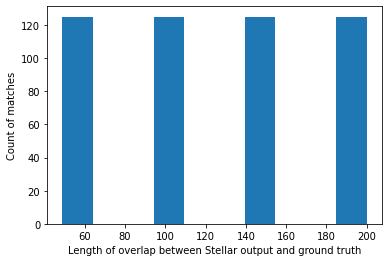

In [111]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(overlap_list, density=False, bins=10)  # density=False would make counts
plt.ylabel('Count of matches')
plt.xlabel('Length of overlap between Stellar output and ground truth');